In [1]:
import torch
import torch.nn as nn
import math
from collections import defaultdict
from tqdm import tqdm
from seaborn import heatmap

## Preparación de los datos

In [2]:
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab

In [3]:
#Entradas
data_in = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda', 'el perro come mucho',
          'un perro come croquetas', 'el perro come', 'el gato come croquetas', 'un gato come', 'yo juego mucho', 
          'el juego', 'un juego', 'yo juego un juego', 'el gato come mucho']

#Etiquetas de salida
data_out = ['DA NC V DD NC', 'DD NC V', 'DA NC V DA NC', 'DD NC V NC', 'DA NC V Adv', 'DA NC V', 'DA NC V NC', 
           'DD NC V', 'DP V Adv', 'DA NC', 'DD NC', 'DP V DD NC', 'DA NC V Adv']

In [4]:
voc_in = vocab()
voc_out = vocab()

x = []
y = []
for sent, tags in zip(data_in, data_out):
    x_i = torch.tensor([voc_in[w] for w in sent.split()], dtype=torch.long)
    x.append( x_i )
    y.append( torch.tensor([voc_out[t] for t in tags.split()], dtype=torch.long) )
    
print(x[0])
print(y[0])

tensor([0, 1, 2, 3, 4])
tensor([0, 1, 2, 3, 1])


## Modelo de atención

### Normalización de capas

In [5]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

### Codificación posicional

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + torch.autograd.Variable(self.pe[:x.size(0), :x.size(1)], requires_grad=False).reshape(x.shape)

        return x

### Capa de atención

In [7]:
class Attention(nn.Module):
    def __init__(self, d_model):
        super(Attention, self).__init__()
        self.Q = nn.Linear(d_model, d_model, bias=False)
        self.K  = nn.Linear(d_model, d_model, bias=False)
        self.V  = nn.Linear(d_model, d_model, bias=False)
        
        self.d_model = d_model
        
    def forward(self, x):       
        query,key,value=self.Q(x),self.K(x),self.V(x)
        
        scores = torch.matmul(query, key.T)/math.sqrt(self.d_model)
        p_attn = torch.nn.functional.softmax(scores, dim = -1)
        
        Vs = torch.matmul(p_attn, value).reshape(x.shape)
        
        return Vs, p_attn

### Modelo atencional

In [13]:
class AttentionModel(nn.Module):
    def __init__(self, len_in, len_out, d_model=128):
        super(AttentionModel, self).__init__()
        self.emb = nn.Embedding(len_in, d_model)
        self.pe = PositionalEncoding(d_model)
        self.att = Attention(d_model)
        self.norm = LayerNorm(d_model)
        self.ffw = nn.Sequential(nn.Linear(d_model,d_model),nn.Tanh(),nn.Linear(d_model,len_out),nn.Softmax(1))
        
        self.att_matrix = None
        
    def forward(self, x):
        x_emb = self.pe(self.emb(x))
        #x_emb = self.emb(x)
        x_emb = self.norm(x_emb)
        h, self.att_matrix = self.att(x_emb)
        h = x_emb + h
        h = self.norm(h) 
        out = self.ffw(h)
        
        return out

In [14]:
model = AttentionModel(len(voc_in), len(voc_out), d_model=16)
model.load_state_dict(torch.load('TaggerModel.model'))

<All keys matched successfully>

In [10]:
epochs = 100
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)
for t in tqdm(range(epochs)):
    for x_i, y_i in zip(x, y):
        y_pred = model(x_i)
        optimizer.zero_grad()
        loss = criterion(y_pred, y_i)
        loss.backward()
        optimizer.step()

100%|██████████| 100/100 [00:02<00:00, 49.78it/s]


In [15]:
tags_voc = {v:k for k,v in voc_out.items()}
def tagger(sent):
    x = torch.tensor([voc_in[w] for w in sent.split()], dtype=torch.long)
    prob = model(x)
    tags = prob.argmax(axis=1)
    tags = [tags_voc[int(i)] for i in tags]
    att = model.att_matrix
    heatmap(att.detach().numpy(), xticklabels=sent.split(), yticklabels=sent.split())
    
    return tags

['DP', 'V', 'Adv', 'DA', 'NC']

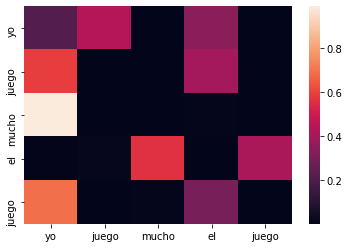

In [16]:
tagger('yo juego mucho el juego')

In [13]:
#torch.save(model.state_dict(), 'TaggerModel.model')